In [ ]:
# pip install tensorflow keras numpy matplotlib scikit-learn opencv-python

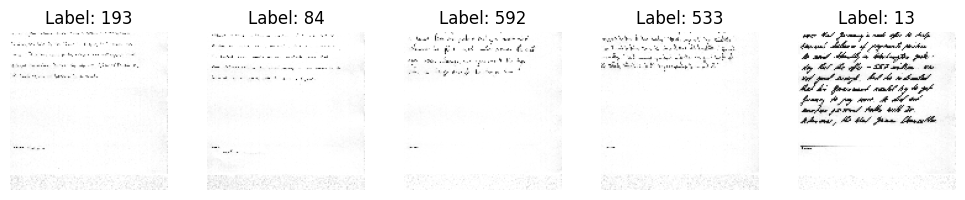

In [10]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

def load_images(data_dir, image_size=(128, 128), crop_area=None):
    images = []
    labels = []
    label_map = {}
    current_label = 0

    for root, dirs, files in os.walk(data_dir):
        for subdir in dirs:
            writer_dir = os.path.join(root, subdir)
            for filename in os.listdir(writer_dir):
                file_path = os.path.join(writer_dir, filename)
                if filename.endswith('.png') or filename.endswith('.jpg'):
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if crop_area:
                        x, y, w, h = crop_area
                        img = img[y:y+h, x:x+w]  # Crop the image
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    if subdir not in label_map:
                        label_map[subdir] = current_label
                        current_label += 1
                    labels.append(label_map[subdir])

    images = np.array(images)
    labels = np.array(labels)
    images = images / 255.0  # Normalize pixel values
    images = images.reshape(-1, image_size[0], image_size[1], 1)  # Add channel dimension
    labels = to_categorical(labels, num_classes=current_label)  # One-hot encode labels
    
    return train_test_split(images, labels, test_size=0.2, random_state=42)

data_dir = r'C:\Users\Dell\Downloads\Handwriting data'  # Set your path here

# Define the crop area (x, y, width, height)
crop_area = (300, 900, 2400, 2800)  # Adjust these values based on your images

X_train, X_test, y_train, y_test = load_images(data_dir, image_size=(128, 128), crop_area=crop_area)

# Plotting some of the images after resizing and cropping
def plot_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title(f'Label: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 5 images from the training set
plot_images(X_train, y_train)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Assuming x_train, y_train, x_val, y_val are defined and y_train is one-hot encoded
input_shape = (128, 128, 1)
num_classes = y_train.shape[1]

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = create_model(input_shape, num_classes)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

model.summary()


C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 824ms/step - accuracy: 0.0034 - loss: 6.9994 - val_accuracy: 0.0065 - val_loss: 7.5311 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 789ms/step - accuracy: 0.0121 - loss: 6.8174 - val_accuracy: 0.0065 - val_loss: 10.0566 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 758ms/step - accuracy: 0.0287 - loss: 6.6520 - val_accuracy: 0.0032 - val_loss: 9.0841 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 763ms/step - accuracy: 0.0302 - loss: 6.5108 - val_accuracy: 0.0000e+00 - val_loss: 11.8271 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 860ms/step - accuracy: 0.0549 - loss: 6.2486 - val_accuracy: 0.0032 - val_loss: 11.4949 - learning_rate: 0.0010
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 899ms/step - accuracy: 0.0494 - loss: 6.0628 - val_accuracy: 0.0000e+00 - val_loss: 11.2094 - learning_rate: 0.0010
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 863ms/step - accuracy: 0.0630 - l

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 657)            │        84,753 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,169,269 (38.79 MB)

 Trainable params: 3,389,521 (12.93 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 6,779,044 (25.86 MB)

In [16]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step - accuracy: 0.0507 - loss: 5.6174 - val_accuracy: 0.0283 - val_loss: 6.8839
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - accuracy: 0.0400 - loss: 5.6360 - val_accuracy: 0.0283 - val_loss: 7.0210
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.0426 - loss: 5.6840 - val_accuracy: 0.0405 - val_loss: 6.7756
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.0377 - loss: 5.5774 - val_accuracy: 0.0283 - val_loss: 6.6856
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - accuracy: 0.0481 - loss: 5.6099 - val_accuracy: 0.0364 - val_loss: 6.7032
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 309ms/step - accuracy: 0.0405 - loss: 5.5591 - val_accuracy: 0.0283 - val_loss: 6.7075
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - accuracy: 0.0436 - loss: 5.5126 - val_accuracy: 0.0283 - val_loss: 6.7741
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.0301 - loss: 5.5848 - val_accur

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.0023 - loss: 7.4996
Test accuracy: 0.006493506487458944


In [14]:
model.save('handwriting_validation_model.h5')

In [6]:
from tensorflow.keras.models import load_model

model = load_model('handwriting_validation_model.h5')

def validate_handwriting(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = img.reshape(1, 128, 128, 1)
    
    prediction = model.predict(img)
    predicted_label = np.argmax(prediction, axis=1)
    
    return predicted_label

# Example usage
new_image_path = 'path to image of handwriting needs to be validated'
result = validate_handwriting(new_image_path)
print(f'Predicted writer label: {result}')

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
